# What makes a playlist successful?

* Analysis
    * Design metric:
        * 30s listens/tot listens (listen conversions)
        * users both months/users prev month (user conversions)
        * best small time performers (less than X total monthly listens + high conversion)
        * best new user playlist (owner has only 1 popular playlist)
    * Define "top": binary top 10%, binary top 1%
* Slide deck
* Web App 
    * simulates playlist metadata; generates performance estimate

## Imports

In [75]:
# basic packages
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import random
import copy

# visualization packages
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns; sns.set()
import graphviz 

# stats packages
import scipy.stats as stats
from scipy.spatial.distance import cdist
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sklearn preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# sklearn modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.mixture import GaussianMixture

# sklearn evaluation
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score


In [2]:
df = pd.read_csv("playlist_summary_external-4.txt", delimiter='\t')

In [76]:
df.head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
0,spotify:user:36069af6af076ccd9e597184a67b68c9:...,36069af6af076ccd9e597184a67b68c9,27,27,1,1,3,3,0,8,0,US,52,0,4,7,30,27,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",Dance & House,New Age,Country & Folk,Peaceful,Romantic,Somber
1,spotify:user:d1144a65b1c31c5f9f56b94f831124d5:...,d1144a65b1c31c5f9f56b94f831124d5,0,0,0,1,2,1,1,3,0,US,131,0,112,113,112,94,"[""good"", ""living""]",Pop,Indie Rock,Alternative,Excited,Yearning,Defiant
2,spotify:user:6b7fbed9edd6418ddd3b555bba441536:...,6b7fbed9edd6418ddd3b555bba441536,4,2,1,1,7,5,0,15,0,US,43,0,35,36,63,0,"[""norte\u00f1a""]",Latin,-,-,Lively,Upbeat,Romantic
3,spotify:user:580b98725077a94c3c8d01d07390426b:...,580b98725077a94c3c8d01d07390426b,12,12,1,1,4,6,1,10,0,US,27,1,27,26,154,108,[],Dance & House,Electronica,Pop,Excited,Aggressive,Defiant
4,spotify:user:1305d39070c95d161cc502e15014897d:...,1305d39070c95d161cc502e15014897d,20,4,1,1,2,1,1,2,1,US,52,0,47,51,230,0,"[""cheesy"", ""pants""]",Indie Rock,Alternative,Electronica,Excited,Defiant,Yearning


In [77]:
df.tail()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
403361,spotify:user:4672952d42bdd93b9215ce9a40394ea6:...,4672952d42bdd93b9215ce9a40394ea6,18,6,2,6,13,12,8,20,1,US,48,0,44,48,464,43,"[""discover"", ""mix""]",Indie Rock,Alternative,Dance & House,Excited,Yearning,Energizing
403362,spotify:user:28c4378e099b4843f5dd42bb848c78ea:...,28c4378e099b4843f5dd42bb848c78ea,0,0,0,0,2,1,1,3,0,US,182,27,114,129,44,14,"[""ambient"", ""study"", ""music""]",Electronica,Dance & House,Rap,Sensual,Excited,Brooding
403363,spotify:user:1c54302dc7e610a10c51eed81e26a168:...,1c54302dc7e610a10c51eed81e26a168,0,0,0,2,2,0,0,2,0,US,36,0,16,15,82,80,"[""october""]",Rap,Indie Rock,Alternative,Brooding,Defiant,Sophisticated
403364,spotify:user:adc973443cdf1abecdfb4244e530d451:...,adc973443cdf1abecdfb4244e530d451,0,0,0,0,2,0,0,2,0,US,50,0,25,25,2,0,[],Rap,R&B,Latin,Defiant,Energizing,Aggressive
403365,spotify:user:b3752c94e387192b7950b687453bcf45:...,b3752c94e387192b7950b687453bcf45,74,16,1,1,2,1,1,3,1,US,348,10,281,290,216,178,"[""eclecticism""]",Rap,Rock,Alternative,Defiant,Energizing,Cool


In [81]:
df.sort_values('users', ascending=False).head()

,playlist_uri,owner,streams,stream30s,dau,wau,mau,mau_previous_month,mau_both_months,users,skippers,owner_country,n_tracks,n_local_tracks,n_artists,n_albums,monthly_stream30s,monthly_owner_stream30s,tokens,genre_1,genre_2,genre_3,mood_1,mood_2,mood_3
152032,spotify:user:spotify:playlist:5FJXhjdILmRA2z5b...,spotify,2527075,1461324,152929,669966,1944150,1478684,578391,3455406,86162,US,51,0,51,51,42497334,22,"[""top"", ""hits""]",Pop,R&B,Dance & House,Excited,Cool,Brooding
163726,spotify:user:spotify:playlist:4hOKQuZbraPDIfaG...,spotify,2629715,1513237,122005,514627,1453097,970905,364140,2448881,56707,US,100,0,93,86,40722305,0,"[""top"", ""tracks"", ""currently"", ""spotify""]",Pop,Dance & House,Indie Rock,Excited,Defiant,Energizing
216752,spotify:user:spotify:playlist:3ZgmfR6lsnCwdffZ...,spotify,735281,348391,43498,219817,688999,365968,109688,1233952,34145,US,100,0,100,99,9879201,0,"[""top"", ""pop"", ""tracks"", ""spotify""]",Pop,R&B,Rap,Excited,Defiant,Empowering
401060,spotify:user:spotify:playlist:3MlpudZs4HT3i0yG...,spotify,505876,245377,33152,121173,430129,339921,79443,973788,23846,US,43,0,41,42,5567649,44,"[""teen"", ""party""]",Pop,R&B,Rap,Excited,Yearning,Urgent
307283,spotify:user:spotify:playlist:04MJzJlzOoy5bTyt...,spotify,252309,124903,16480,68518,278966,448102,75371,917174,11888,US,296,0,1,1,4178965,8,"[""dance"", ""mega"", ""mix""]",Dance & House,Electronica,Pop,Excited,Aggressive,Energizing


In [79]:
df.iloc[403361,0]

'spotify:user:4672952d42bdd93b9215ce9a40394ea6:playlist:6W45lqDBZ1TKma71Uu2F5x'

In [4]:
df.columns

Index(['playlist_uri', 'owner', 'streams', 'stream30s', 'dau', 'wau', 'mau',
       'mau_previous_month', 'mau_both_months', 'users', 'skippers',
       'owner_country', 'n_tracks', 'n_local_tracks', 'n_artists', 'n_albums',
       'monthly_stream30s', 'monthly_owner_stream30s', 'tokens', 'genre_1',
       'genre_2', 'genre_3', 'mood_1', 'mood_2', 'mood_3'],
      dtype='object')

In [74]:
id = [df.columns[0], df.columns[1]]
targets = list(df.columns[2:11]) + ["monthly_stream30s", "monthly_owner_stream30s"]
features = set(df.columns) - set(targets) - set(id)
features = list(features)

print(f"id columns: {id}")
print(f"target columns: {targets}")
print(f"feature columns: {features}")

id columns: ['playlist_uri', 'owner']
target columns: ['streams', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'mau_both_months', 'users', 'skippers', 'monthly_stream30s', 'monthly_owner_stream30s']
feature columns: ['n_tracks', 'mood_2', 'tokens', 'genre_3', 'owner_country', 'genre_2', 'genre_1', 'mood_3', 'n_artists', 'n_albums', 'n_local_tracks', 'mood_1']


`stream30s`, `dau`, `wau`, `mau`, `monthly_stream30s`, `monthly_owner_stream30s`, `mau_previous_months` and `mau_both_months` are all specifically for users who have streamed the playlist for over 30 seconds

Let's make the north star metric

* `mau_previous_month` - tells us how many users have streamed over 30 seconds from the playlist this past month
    * **downside**: since we don't know when the playlist was created, we may falsely label some playlists as having low rate of success

Let's make a guardrail metric

* `mau_both_months` - tells us if the playlist has replay value
    * **downside**: since we don't know when the playlist was created, we don't know at what stage the playlist is in its lifetime, i.e. do users fall off from months 1-2 or months 10-11
    
* `stream30s` - number of streams over 30 seconds today; tells us demand of playlist unormalized by number of users accessing the stream (i.e. some users will stream multiple times)
    * **downside** - a few users can dominate the overall number of listens
    
* `monthly_stream30s` - number of streams over 30 seconds for the month; will give us a longer term comparison between streams
    * **downside** - playlists created at some point in the month will be compared unequally
    
Secondary metric

* `monthly_owner_stream30s` - tells us if the owner or the playlist is significant in making a successful playlist; semi-feature column

In [6]:
sub_targets = ['mau_previous_month', 'mau_both_months', 'monthly_stream30s', 'stream30s']

## Depenent Variable

it looks like `mau` may be from an incomplete month (comparing the frequency to `mau_previous_months`)

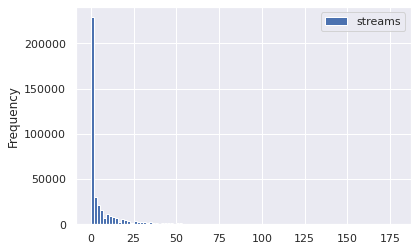

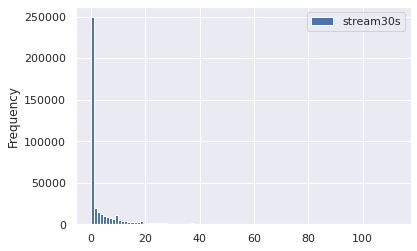

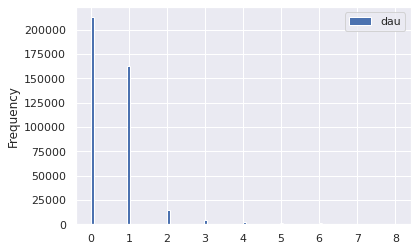

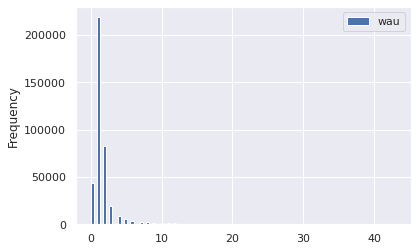

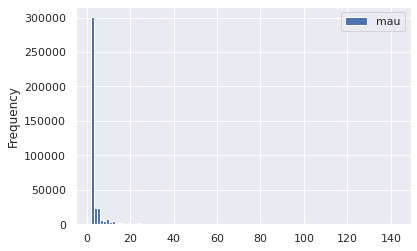

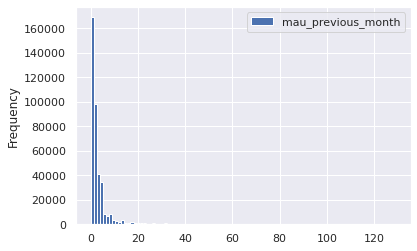

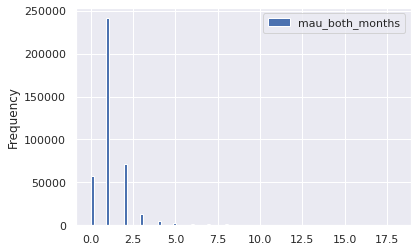

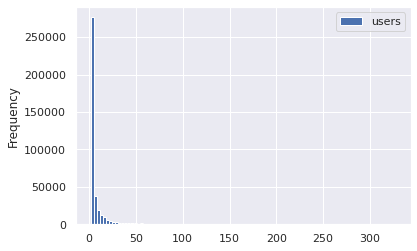

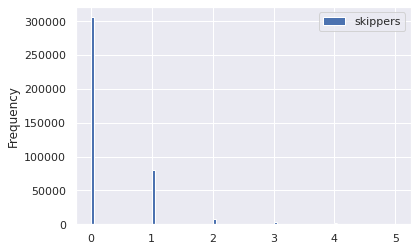

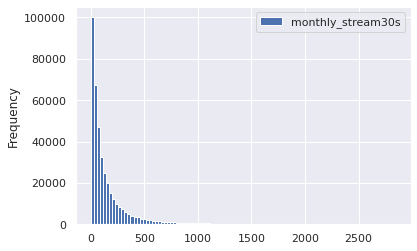

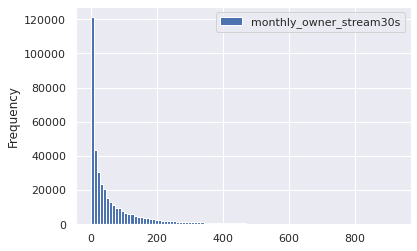

In [7]:
quant = 0.99
for target in targets:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    y.plot(kind='hist', y=target, bins=100)

removed items: 1212


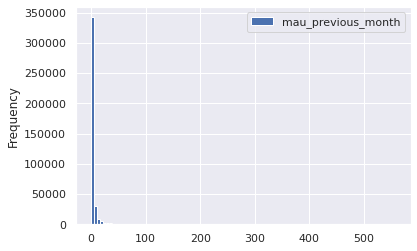

removed items: 1216


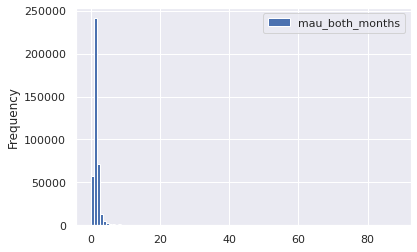

removed items: 1211


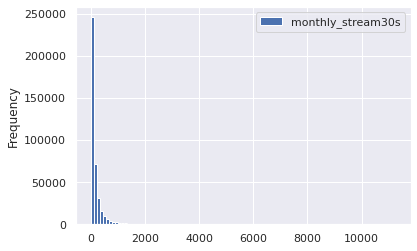

removed items: 1211


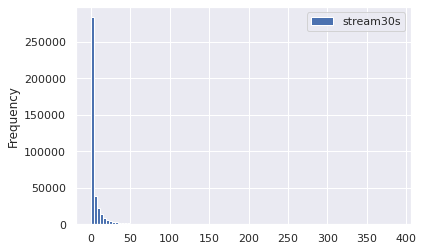

In [8]:
quant = 0.997
for target in sub_targets:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    removed = df.loc[~(df[target] < cutoff)]
    print(f"removed items: {removed.shape[0]}")
    y.plot(kind='hist', y=target, bins=100)
    plt.show()

In [9]:
df[sub_targets].describe()

,mau_previous_month,mau_both_months,monthly_stream30s,stream30s
count,4.033660e+05,403366.000000,4.033660e+05,4.033660e+05
mean,5.819009e+01,12.937065,1.260489e+03,4.283333e+01
std,3.827248e+03,1240.912979,1.062463e+05,3.772412e+03
min,0.000000e+00,0.000000,2.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000,3.100000e+01,0.000000e+00
50%,2.000000e+00,1.000000,7.900000e+01,0.000000e+00
75%,3.000000e+00,2.000000,1.930000e+02,5.000000e+00
max,1.478684e+06,578391.000000,4.249733e+07,1.513237e+06


## Independent Variable

In [10]:
features

['n_tracks',
 'mood_2',
 'tokens',
 'genre_3',
 'owner_country',
 'genre_2',
 'genre_1',
 'mood_3',
 'n_artists',
 'n_albums',
 'n_local_tracks',
 'owner',
 'mood_1']

In [11]:
df[features].head()

,n_tracks,mood_2,tokens,genre_3,owner_country,genre_2,genre_1,mood_3,n_artists,n_albums,n_local_tracks,owner,mood_1
0,52,Romantic,"[""ambient"", ""music"", ""therapy"", ""binaural"", ""b...",Country & Folk,US,New Age,Dance & House,Somber,4,7,0,36069af6af076ccd9e597184a67b68c9,Peaceful
1,131,Yearning,"[""good"", ""living""]",Alternative,US,Indie Rock,Pop,Defiant,112,113,0,d1144a65b1c31c5f9f56b94f831124d5,Excited
2,43,Upbeat,"[""norte\u00f1a""]",-,US,-,Latin,Romantic,35,36,0,6b7fbed9edd6418ddd3b555bba441536,Lively
3,27,Aggressive,[],Pop,US,Electronica,Dance & House,Defiant,27,26,1,580b98725077a94c3c8d01d07390426b,Excited
4,52,Defiant,"[""cheesy"", ""pants""]",Electronica,US,Alternative,Indie Rock,Yearning,47,51,0,1305d39070c95d161cc502e15014897d,Excited


In [12]:
con_features = list(df[features].select_dtypes('number').columns)
print(con_features)
des_features = list(df[features].select_dtypes('object').columns)
print(des_features)

['n_tracks', 'n_artists', 'n_albums', 'n_local_tracks']
['mood_2', 'tokens', 'genre_3', 'owner_country', 'genre_2', 'genre_1', 'mood_3', 'owner', 'mood_1']


In [13]:
df[des_features].describe()

,mood_2,tokens,genre_3,owner_country,genre_2,genre_1,mood_3,owner,mood_1
count,403366,403366,403366,403366,403366,403366,403366,403366,403366
unique,27,192107,26,1,26,26,27,314899,27
top,Energizing,[],Pop,US,Alternative,Indie Rock,Energizing,spotify,Defiant
freq,51643,32568,78758,403366,66252,70571,56450,399,81079


we will go ahead and remove `owner_country` (1 unique), `owner`, and `tokens` (cardinal) from our feature analysis

In [14]:
id = [df.columns[0]]
targets = list(df.columns[2:11]) + ["monthly_stream30s", "monthly_owner_stream30s"]
features = set(df.columns) - set(targets) - set(id) - set(["owner_country", "owner", "tokens"])
features = list(features)

print(f"id columns: {id}")
print(f"target columns: {targets}")
print(f"feature columns: {features}")

con_features = list(df[features].select_dtypes('number').columns)
print(con_features)
des_features = ['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']
print(des_features)

id columns: ['playlist_uri']
target columns: ['streams', 'stream30s', 'dau', 'wau', 'mau', 'mau_previous_month', 'mau_both_months', 'users', 'skippers', 'monthly_stream30s', 'monthly_owner_stream30s']
feature columns: ['n_tracks', 'mood_2', 'genre_3', 'genre_2', 'genre_1', 'mood_3', 'n_artists', 'n_albums', 'n_local_tracks', 'mood_1']
['n_tracks', 'n_artists', 'n_albums', 'n_local_tracks']
['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']


### Discrete Features

In [15]:
df[des_features].describe()

,mood_1,mood_2,mood_3,genre_1,genre_2,genre_3
count,403366,403366,403366,403366,403366,403366
unique,27,27,27,26,26,26
top,Defiant,Energizing,Energizing,Indie Rock,Alternative,Pop
freq,81079,51643,56450,70571,66252,78758


In [16]:
df.value_counts(des_features)

mood_1    mood_2      mood_3      genre_1        genre_2        genre_3
Excited   Aggressive  Energizing  Dance & House  Electronica    Pop        4824
Defiant   Cool        Energizing  Rap            R&B            Pop        4458
          Energizing  Cool        Rap            R&B            Pop        4003
                                                 Pop            R&B        1803
                      Excited     Rap            Pop            R&B        1225
                                                                           ... 
Excited   Aggressive  Urgent      Alternative    Electronica    Metal         1
                                                 Dance & House  Pop           1
                      Upbeat      Pop            Soundtrack     -             1
                                  Indie Rock     Alternative    -             1
Yearning  Urgent      Upbeat      Soundtrack     Pop            Rap           1
Length: 138379, dtype: int64

In [17]:
df[des_features[:3]].value_counts()

mood_1    mood_2      mood_3    
Defiant   Cool        Energizing    15125
          Energizing  Cool          12278
Excited   Aggressive  Energizing     7564
Defiant   Energizing  Excited        6672
          Excited     Energizing     6179
                                    ...  
Peaceful  Urgent      Yearning          1
          Yearning    Cool              1
                      Excited           1
                      Fiery             1
Other     Urgent      Aggressive        1
Length: 9326, dtype: int64

In [18]:
df[des_features[3:]].value_counts()

genre_1        genre_2         genre_3    
Rap            R&B             Pop            15477
Indie Rock     Alternative     Rock           13102
Dance & House  Electronica     Pop            10800
Indie Rock     Alternative     Pop             9981
                               Electronica     7233
                                              ...  
New Age        Country & Folk  Rock               1
               Dance & House   R&B                1
                               Rock               1
                               Soundtrack         1
Traditional    Spoken & Audio  Religious          1
Length: 6664, dtype: int64

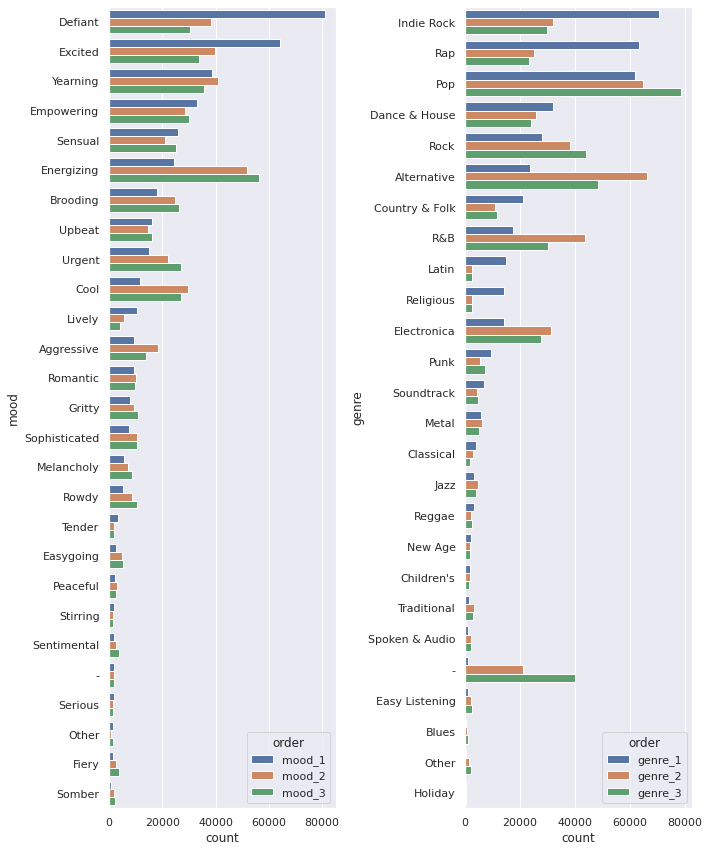

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10,12))

dff = pd.DataFrame(df[des_features[0]].value_counts()).join(
    pd.DataFrame(df[des_features[1]].value_counts())).join(
    pd.DataFrame(df[des_features[2]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['mood', 'order', 'count']
sns.barplot(data=dff, hue='order', y='mood', x='count', orient='h', ax=ax[0])

dff = pd.DataFrame(df[des_features[3]].value_counts()).join(
    pd.DataFrame(df[des_features[4]].value_counts())).join(
    pd.DataFrame(df[des_features[5]].value_counts()))
dff = dff.reset_index().melt(id_vars='index')
dff.columns = ['genre', 'order', 'count']
sns.barplot(data=dff, hue='order', y='genre', x='count', orient='h', ax=ax[1])

plt.tight_layout()

### Continuous Features

In [20]:
df[con_features].describe()

,n_tracks,n_artists,n_albums,n_local_tracks
count,403366.000000,403366.000000,403366.000000,403366.000000
mean,201.483432,83.852050,88.224250,3.084035
std,584.077765,128.152488,133.193118,40.330266
min,1.000000,1.000000,1.000000,0.000000
25%,38.000000,18.000000,19.000000,0.000000
50%,84.000000,46.000000,48.000000,0.000000
75%,192.000000,100.000000,106.000000,0.000000
max,79984.000000,5226.000000,6397.000000,9117.000000


removed items: 404


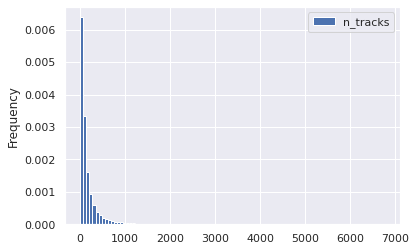

removed items: 405


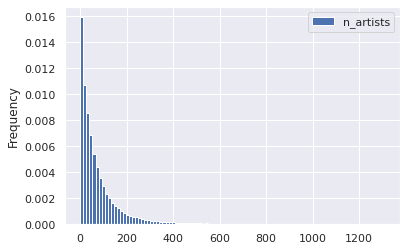

removed items: 404


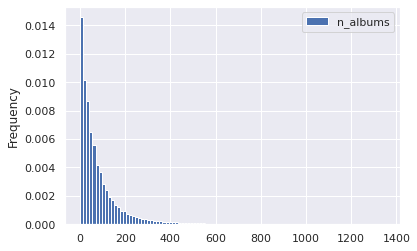

removed items: 406


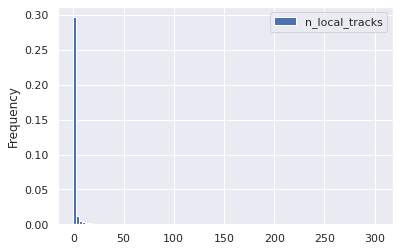

In [21]:
quant = 0.999
for target in con_features:
    cutoff = np.quantile(df[target], quant)
    y = df.loc[df[target] < cutoff]
    removed = df.loc[~(df[target] < cutoff)]
    print(f"removed items: {removed.shape[0]}")
    y.plot(kind='hist', y=target, bins=100, density=True)
    plt.show()

#### Bootstrapping

An example of how we will bootstrap to perform hypothesis tests later on

In [23]:
means = []
ind = con_features[0]
for i in range(100):
    boot = random.sample(
                list(
                    df.loc[
                        (df[ind] > 9) 
                        & (df[ind] < 999)
                    ][ind].values),
                k=1000)
    means.append(np.mean(boot))

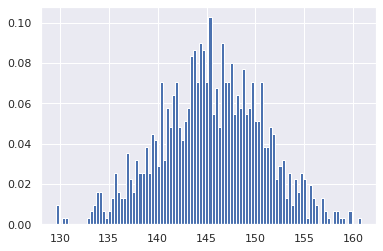

In [24]:
stuff = plt.hist(means, bins=100, density=True)

## Dependency

### Categorical Target

In [25]:
sub_targets

['mau_previous_month', 'mau_both_months', 'monthly_stream30s', 'stream30s']

In [26]:
des_features

['mood_1', 'mood_2', 'mood_3', 'genre_1', 'genre_2', 'genre_3']

#### Categorical Feature

##### Moods

In [27]:
chidf = pd.DataFrame()
target = sub_targets[2]
chidf[target] = df[target]
print(chidf[target].median())
moods = pd.DataFrame()
cutoff = 0.001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]
    
    for grp_label in df[ind].unique():
        # grp_label = df[ind].unique()[0]
        grp = chidf.loc[chidf[ind] == grp_label][target].values
        chi2, p, m, cTable = stats.median_test(grp, pop, correction=True)
        ratio = cTable[0]/cTable[1]
        pos = ratio[0]/ratio[1] > 1
        moods = pd.concat([moods, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])

moods.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', '+', 'reject null']
moods = moods.sort_values('p-value').reset_index(drop=True)

79.0


In [28]:
moods.loc[moods['reject null'] == True]

,feature,group,chi,p-value,cTable,+,reject null
0,genre_3,-,1725.882036,0.000000e+00,"[[16033, 205049], [24090, 198317]]",False,True
1,genre_2,-,1104.759466,3.051013e-242,"[[8216, 203517], [12990, 199849]]",False,True
2,genre_1,Latin,651.374931,1.122254e-143,"[[9000, 199027], [6012, 204339]]",True,True
3,mood_1,Energizing,611.189037,6.167816e-135,"[[10316, 203517], [14071, 199849]]",False,True
4,genre_1,Rock,315.827189,1.174487e-70,"[[12514, 201911], [15563, 201455]]",False,True
...,...,...,...,...,...,...,...
93,mood_1,Stirring,12.333846,4.448190e-04,"[[877, 200454], [1044, 202912]]",False,True
94,mood_1,Serious,12.316512,4.489689e-04,"[[778, 200454], [935, 202912]]",False,True
95,mood_2,Lively,12.161071,4.879735e-04,"[[2588, 200454], [2882, 202912]]",False,True
96,mood_2,Somber,11.618507,6.529880e-04,"[[792, 200454], [946, 202912]]",False,True


##### Chi-Square

In [29]:
chidf = pd.DataFrame()
target = sub_targets[2]
chidf[target] = df[target]
quant_value = 0.90
tar_value = np.quantile(chidf[target], quant_value)
chidf[target] = chidf[target] > tar_value
chisum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in des_features:
    # ind = des_features[0]
    chidf[ind] = df[ind]

    for grp_label in df[ind].unique():
    # grp_label = df[ind].unique()[0]
        try:
            cTable = chidf.groupby(chidf[ind] == grp_label)[target].value_counts().values.reshape(2,2).T
            chi2, p, dof, ex = stats.chi2_contingency(cTable, correction=True, lambda_=None)
            ratio = cTable[1]/cTable[0]
            pos = ratio[1]/ratio[0]
            chisum = pd.concat([chisum, pd.DataFrame([[ind, grp_label, chi2, p, cTable, pos, p<cutoff]])])
        except:
            pass

chisum.columns = ['feature', 'group', 'chi', 'p-value', 'cTable', 'multiplier', 'reject null']
chisum = chisum.sort_values('p-value').reset_index(drop=True)

##### Categorical-Categorical Conclusions

increasing `quant_value` will render additional features; as the population performance worsens, new feature/group pairs have an opportunity to increase the multiplier

Best Groups

In [30]:
chisum.loc[(chisum['reject null'] == True) & (chisum['multiplier'] > 2)].sort_values('multiplier', ascending=False)

,feature,group,chi,p-value,cTable,multiplier,reject null
6,genre_1,Children's,262.624693,4.596280e-59,"[[361785, 1286], [39933, 362]]",2.550270,True
11,mood_1,Other,197.598843,6.979647e-45,"[[361719, 1352], [39952, 343]]",2.296943,True
19,genre_1,Spoken & Audio,120.508309,4.896128e-28,"[[362147, 924], [40068, 227]]",2.220451,True
0,genre_1,Latin,1150.625294,3.280867e-252,"[[350782, 12289], [37572, 2723]]",2.068731,True
12,genre_1,New Age,166.484617,4.335181e-38,"[[361286, 1785], [39896, 399]]",2.024214,True


Worst Groups

In [31]:
chisum.loc[(chisum['reject null'] == True) & (chisum['multiplier'] < 0.8)].sort_values('multiplier', ascending=False)

,feature,group,chi,p-value,cTable,multiplier,reject null
28,mood_2,Sensual,85.309680,2.551113e-20,"[[343873, 19198], [38598, 1697]]",0.787516,True
40,genre_1,Electronica,65.249731,6.598320e-16,"[[350162, 12909], [39176, 1119]]",0.774794,True
2,genre_1,Indie Rock,366.567076,1.046303e-81,"[[298164, 64907], [34631, 5664]]",0.751315,True
13,genre_3,Electronica,163.908151,1.584260e-37,"[[337501, 25570], [38143, 2152]]",0.744684,True
21,mood_1,Brooding,109.456909,1.288759e-25,"[[346296, 16775], [38893, 1402]]",0.744152,True
48,mood_1,Gritty,49.741710,1.753777e-12,"[[355800, 7271], [39695, 600]]",0.739652,True
14,mood_1,Energizing,162.542129,3.149562e-37,"[[340541, 22530], [38438, 1857]]",0.730229,True
68,mood_3,Other,27.407286,1.648091e-07,"[[361541, 1530], [40196, 99]]",0.581994,True


We would recommend would-be superstar playlist maker construct a playlist with the following attributes:

* **Genre 1: Children's** 
    * 2.6x more likely to be in the 90th percentile
    * 4.8x more likely to be in the 99th percentile
* **Mood 1: Other** 
    * 2.3x more likely to be in the 90th percentile
    * 2.4x more likely to be in the 99th percentile

#### Continuous Feature

In [32]:
con_features

['n_tracks', 'n_artists', 'n_albums', 'n_local_tracks']

##### t-Test

For t tests we need to deal with the long tails in the distributions along the independent variable

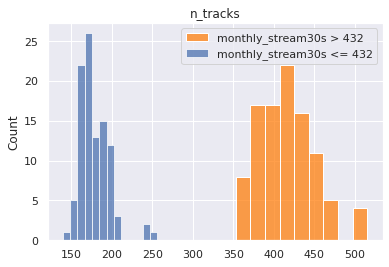

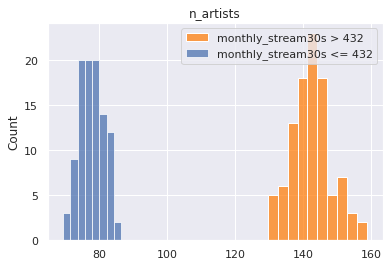

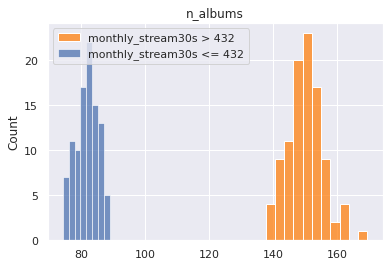

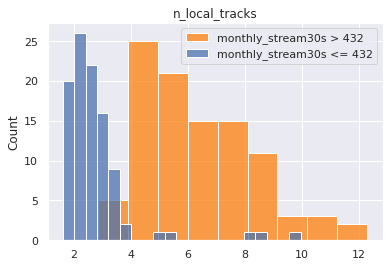

In [39]:
chidf = pd.DataFrame()
target = sub_targets[2]
chidf[target] = df[target]
quant_value = 0.90
tar_value = np.quantile(chidf[target], quant_value)
chidf[target] = chidf[target] > tar_value
welchsum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in con_features:
    # ind = con_features[0]
    chidf[ind] = df[ind]

    # for grp_label in df[ind].unique():
    # try:
    a = []
    b = []
    for i in range(100):
        boot1 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == True)
                        ][ind].values),
                    k=1000)
        boot2 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == False)
                        ][ind].values),
                    k=1000)
        a.append(np.mean(boot1))
        b.append(np.mean(boot2))
    testt, p = stats.ttest_ind(a, b, equal_var=False)
    a_avg = np.mean(a)
    b_avg = np.mean(b)
    welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
    sns.histplot(a, color='tab:orange', label=f"{target} > {tar_value:.0f}")
    sns.histplot(b, label=f"{target} <= {tar_value:.0f}")
    plt.title(ind)
    plt.legend()
    plt.show()
    # except:
    #     pass

welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
welchsum = welchsum.sort_values('p-value').reset_index(drop=True)

In [41]:
welchsum

,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,n_albums,102.048804,9.074982e-151,150.03201,81.86361,True
1,n_artists,93.165040,7.173538e-143,142.27000,77.84331,True
2,n_tracks,60.485334,2.651696e-108,415.45784,177.93975,True
3,n_local_tracks,15.204209,1.507712e-33,6.30652,2.75143,True


Let's perform the same test again this time let's say we're only interested in playlists with at least 10 tracks and fewer than 1000 tracks

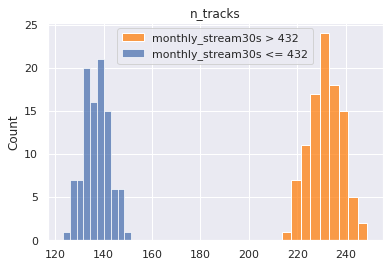

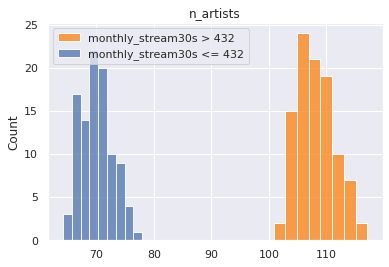

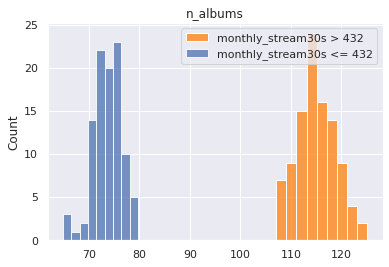

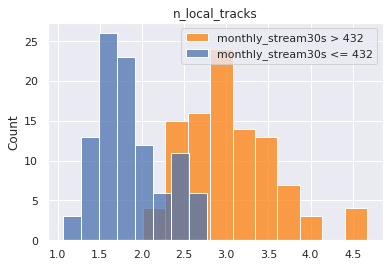

In [42]:
chidf = pd.DataFrame()
target = sub_targets[2]
chidf[target] = df[target]
chidf['n_tracks'] = df['n_tracks']
quant_value = 0.90
tar_value = np.quantile(chidf[target], quant_value)
chidf[target] = chidf[target] > tar_value
welchsum = pd.DataFrame()
cutoff = 0.0001
pop = chidf[target].values

for ind in con_features:
    # ind = con_features[0]
    chidf[ind] = df[ind]

    # for grp_label in df[ind].unique():
    # try:
    a = []
    b = []
    for i in range(100):
        boot1 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == True)
                            & (chidf['n_tracks'] > 9)
                            & (chidf['n_tracks'] < 999)
                        ][ind].values),
                    k=1000)
        boot2 = random.sample(
                    list(
                        chidf.loc[
                            (chidf[target] == False)
                            & (chidf['n_tracks'] > 9)
                            & (chidf['n_tracks'] < 999)
                        ][ind].values),
                    k=1000)
        a.append(np.mean(boot1))
        b.append(np.mean(boot2))
    testt, p = stats.ttest_ind(a, b, equal_var=False)
    a_avg = np.mean(a)
    b_avg = np.mean(b)
    welchsum = pd.concat([welchsum, pd.DataFrame([[ind, testt, p, a_avg, b_avg, p<cutoff]])])
    sns.histplot(a, color='tab:orange', label=f"{target} > {tar_value:.0f}")
    sns.histplot(b, label=f"{target} <= {tar_value:.0f}")
    plt.title(ind)
    plt.legend()
    plt.show()
    # except:
    #     pass

welchsum.columns = ['feature', 'test stat', 'p-value', 'upper q avg', 'lower q avg', 'reject null']
welchsum = welchsum.sort_values('p-value').reset_index(drop=True)

In [43]:
welchsum

,feature,test stat,p-value,upper q avg,lower q avg,reject null
0,n_tracks,110.782734,1.913718e-173,231.56673,137.09507,True
1,n_artists,87.812155,2.100996e-157,108.08371,70.02189,True
2,n_albums,87.814955,5.432018e-154,114.92906,73.64590,True
3,n_local_tracks,17.294490,5.602552e-40,3.02931,1.85825,True


##### Categorical-Continuous Conclusions

Our conclusions are the same. There is a clear delineation between number of tracks, albums, and artists for popular and unpopular playlists

#### Categorical Target Model

##### Deciles

In [44]:
target

'monthly_stream30s'

In [45]:
y = df[target].values
labels = y.copy()
names = []
for idx, quant in zip(range(11), np.linspace(0, 1, num=11)):
    if idx == 0:
        prev = quant
        continue
    if idx == 1:
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

In [60]:
X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [61]:
X_train.shape

(322692, 163)

In [65]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [66]:
y_hat_test = model.predict(X_test)
print(f"Train Acc: {accuracy_score(y_test, y_hat_test):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

Train Acc: 0.14
Test Acc: 0.14


In [70]:
print(classification_report(y_test, y_hat_test, zero_division=0))

              precision    recall  f1-score   support

           1       0.19      0.27      0.22      8363
           2       0.13      0.13      0.13      7866
           3       0.12      0.12      0.12      8173
           4       0.10      0.09      0.10      7773
           5       0.11      0.10      0.10      8252
           6       0.11      0.10      0.10      7976
           7       0.11      0.09      0.10      8018
           8       0.12      0.10      0.11      8185
           9       0.14      0.14      0.14      8009
          10       0.21      0.26      0.23      8059

    accuracy                           0.14     80674
   macro avg       0.13      0.14      0.14     80674
weighted avg       0.13      0.14      0.14     80674



<AxesSubplot:>

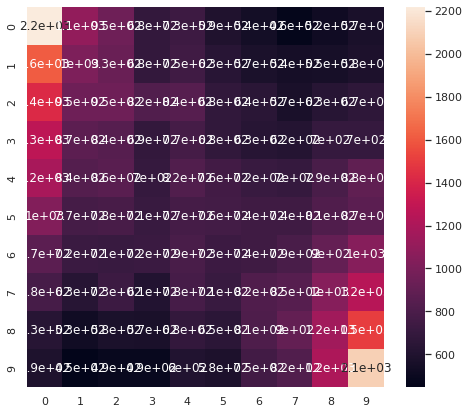

In [71]:
fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

##### Quartiles

Train Acc: 0.99
Test Acc: 0.44
              precision    recall  f1-score   support

           1       0.46      0.49      0.47     26847
           2       0.36      0.31      0.33     26799
           3       0.47      0.50      0.49     27028

    accuracy                           0.44     80674
   macro avg       0.43      0.44      0.43     80674
weighted avg       0.43      0.44      0.43     80674



<AxesSubplot:>

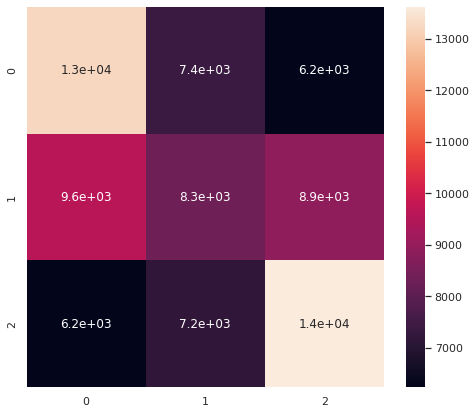

In [73]:
### Create Categories

y = df[target].values
labels = y.copy()
names = []
lim = 4
for idx, quant in zip(range(lim), np.linspace(0, 1, num=lim)):
    if idx == 0:
        prev = quant
        continue
    if idx == 1:
        labels[labels <= np.quantile(y, quant)] = idx
        names += [f"less than {np.quantile(y, quant):.0f} listens"]
    else:
        labels[(labels > np.quantile(y, prev))
              &(labels <= np.quantile(y, quant))] = idx
        names += [f"{np.quantile(y, prev):.0f} < listens <= {np.quantile(y, quant):.0f}"]
    prev = quant
y = labels

### Create Training Data

X = df[des_features + con_features]
enc = OneHotEncoder()
std = StandardScaler()

X_cat = enc.fit_transform(X[des_features]).toarray()
X_con = std.fit_transform(X[con_features])
X = np.hstack((X_con, X_cat))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

### Train Model

model = RandomForestClassifier()
model.fit(X_train, y_train)

### Asses Performance

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print(f"Train Acc: {accuracy_score(y_train, y_hat_train):.2f}")
print(f"Test Acc: {accuracy_score(y_test, y_hat_test):.2f}")

print(classification_report(y_test, y_hat_test, zero_division=0))

fig, ax = plt.subplots(1, 1, figsize = (8,7))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True, ax=ax)

### Continuous Target

#### Linear

#### Ensemble